# PyTorch GAN

We can use PyTorch to implement generative adversarial networks.

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
import copy
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [5]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                               
train_set = datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 39283072.56it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18716887.18it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33424958.90it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2411764.62it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



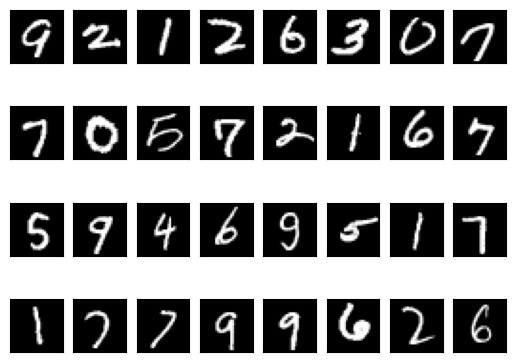

In [6]:
samples, labels = next(iter(train_loader))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Define discriminator and generator models

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

## Training

In [ ]:
def train_gan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function, batch_size):
    for epoch in range(epochs):
        for n, (samples, labels) in enumerate(train_loader):
            # Get data for training the discriminator
            real_samples = samples.to(device=device)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            disc_optimizer.step()

            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            gen_optimizer.step()

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch}, Generator Loss: {loss_generator}, Descriminator Loss: {loss_discriminator}")

In [8]:
lr = 0.0001
epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [9]:
for epoch in range(epochs):
    for n, (samples, labels) in enumerate(train_loader):
        # Get data for training the discriminator
        real_samples = samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch}, Generator Loss: {loss_generator}, Descriminator Loss: {loss_discriminator}")

Epoch: 0 Descrimianted Loss: 0.48063209652900696
Epoch: 0 Generator Loss: 0.8016734719276428
Epoch: 1 Descrimianted Loss: 0.030770402401685715
Epoch: 1 Generator Loss: 9.088944435119629
Epoch: 2 Descrimianted Loss: 0.0005857647629454732
Epoch: 2 Generator Loss: 9.814854621887207
Epoch: 3 Descrimianted Loss: 0.05141633749008179
Epoch: 3 Generator Loss: 8.862184524536133
Epoch: 4 Descrimianted Loss: 0.04971329867839813
Epoch: 4 Generator Loss: 6.502370834350586
Epoch: 5 Descrimianted Loss: 0.0178806371986866
Epoch: 5 Generator Loss: 5.585919380187988
Epoch: 6 Descrimianted Loss: 0.06517550349235535
Epoch: 6 Generator Loss: 3.866830348968506
Epoch: 7 Descrimianted Loss: 0.012708835303783417
Epoch: 7 Generator Loss: 3.844003200531006
Epoch: 8 Descrimianted Loss: 0.07679282128810883
Epoch: 8 Generator Loss: 3.612506866455078
Epoch: 9 Descrimianted Loss: 0.14691859483718872
Epoch: 9 Generator Loss: 3.0840492248535156
Epoch: 10 Descrimianted Loss: 0.2662462592124939
Epoch: 10 Generator Loss: 

KeyboardInterrupt: 

## Generate samples

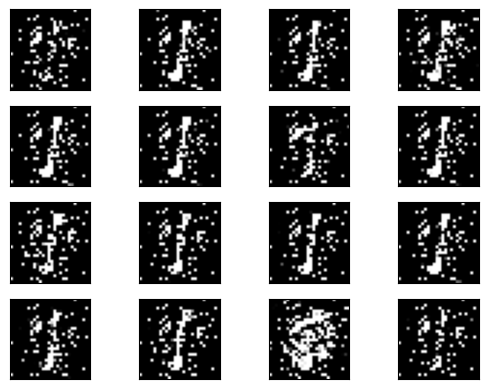

In [10]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Improvements DCGAN
We can improve our models by using Conv layers

In [ ]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, channels=1, num_of_feature_maps=64):
        super().__init__()
        self.model = nn.Sequential(

            nn.Conv2d(channels, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 2, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 4, num_of_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class GeneratorCNN(nn.Module):
    def __init__(self, latent_vector_size=100, num_of_feature_maps=64, channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d( latent_vector_size, num_of_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(num_of_feature_maps * 8, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps * 4, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps * 2, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



discriminator = DiscriminatorCNN().to(device=device)
generator = GeneratorCNN().to(device=device)

In [ ]:
train_gan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function, batch_size)